In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F

pd.set_option('display.max_columns', None)

In [2]:
supervector_df_Standard = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250502_1358\supervector.csv')
print("Supervector DataFrame :")
supervector_df_Standard.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness
0,36.676070,78.346458,200.0,0.0
1,36.602705,78.064495,201.0,0.0
2,36.529937,77.775873,202.0,0.0
3,36.460888,77.485894,203.0,0.0
4,36.468914,77.487824,204.0,0.0


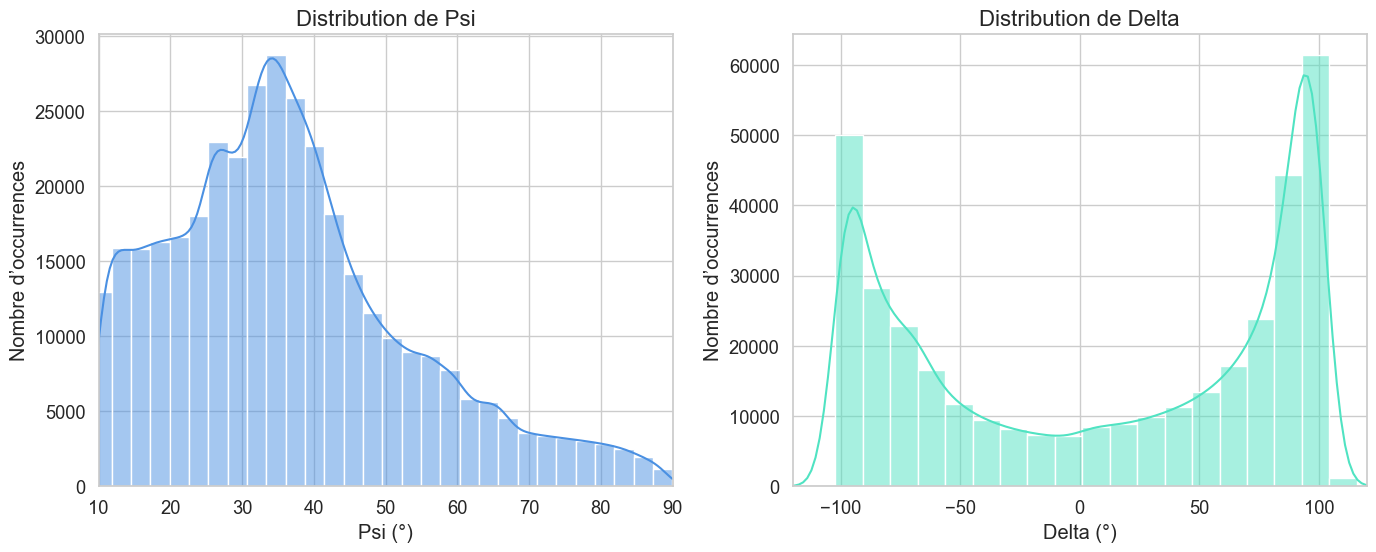

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Style moderne
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["font.family"] = "sans-serif"

# Suppose que supervector_df_Standard est ton DataFrame
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogramme de psi
sns.histplot(supervector_df_Standard["psi"], bins=30, kde=True, ax=axes[0], color="#4A90E2")
axes[0].set_title("Distribution de Psi", fontsize=16)
axes[0].set_xlabel("Psi (°)")
axes[0].set_ylabel("Nombre d’occurrences")
axes[0].set_xlim(10, 90)

# Histogramme de delta
sns.histplot(supervector_df_Standard["delta"], bins=30, kde=True, ax=axes[1], color="#50E3C2")
axes[1].set_title("Distribution de Delta", fontsize=16)
axes[1].set_xlabel("Delta (°)")
axes[1].set_ylabel("Nombre d’occurrences")
axes[1].set_xlim(-120, 120)

# Titre global
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


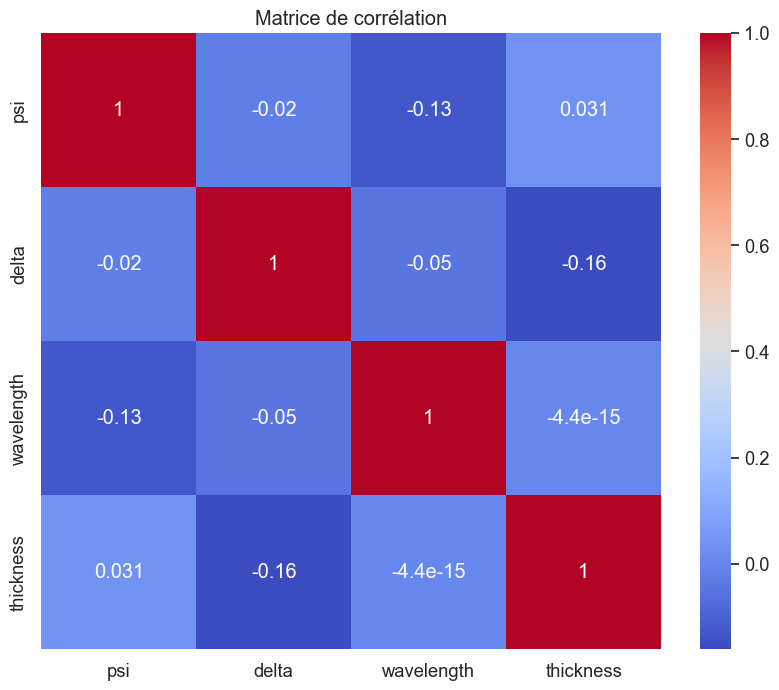

In [4]:
import seaborn as sns

# Matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(supervector_df_Standard.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

In [5]:
def group_and_flatten(df):
    # Déterminer les colonnes de groupement possibles
    possible_group_cols = ['vfraction', 'thickness', 'lambda0', 'gamma', 'amplitude']
    
    # Trouver les colonnes de groupement qui existent dans le dataframe
    group_cols = [col for col in possible_group_cols if col in df.columns]
    
    # Si aucune colonne de groupement n'est trouvée, on peut utiliser une colonne par défaut ou lever une exception
    if not group_cols:
        raise ValueError("Aucune colonne de groupement appropriée trouvée dans le dataframe")
    
    # Effectuer le groupby et le flatten
    grouped = df.groupby(group_cols)[['psi', 'delta']].apply(
        lambda x: x.values.flatten()
    ).reset_index()
    
    # Renommer la colonne résultante
    grouped.columns = list(group_cols) + ['psi_delta_flatten']
    
    return grouped

# Utilisation pour chaque dataset
grouped_standard = group_and_flatten(supervector_df_Standard)


In [6]:
def prepare_and_split_data(grouped_df, test_size=0.2, random_state=42):
    """
    Prépare les données et les divise en gardant les relations entre les variables cibles
    
    Args:
        grouped_df: DataFrame après group_and_flatten
        test_size: proportion pour le test set
        random_state: seed aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test (y conserve toutes les cibles)
        et la liste des noms des cibles
    """
    # Préparation des features et labels
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    y = grouped_df.drop(columns=['psi_delta_flatten']).values
    label_names = grouped_df.drop(columns=['psi_delta_flatten']).columns.tolist()
    
    # Split en gardant toutes les cibles ensemble
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape} (labels: {label_names})")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, label_names

In [7]:
#Pour le dataset Standard (tous les paramètres ensemble)
X_train_std, X_test_std, y_train_std, y_test_std, labels_std = prepare_and_split_data(grouped_standard)

X_train shape: (480, 1202)
X_test shape: (121, 1202)
y_train shape: (480, 1) (labels: ['thickness'])
y_test shape: (121, 1)


In [8]:
def augment_data(X, y, noise_level=0.01, num_augmentations=3):
    """
    Augmente les données en ajoutant du bruit gaussien
    
    Args:
        X: Features (psi_delta_flatten)
        y: Labels (paramètres physiques)
        noise_level: Niveau de bruit relatif (écart-type)
        num_augmentations: Nombre de copies augmentées à créer
    
    Returns:
        X_augmented, y_augmented: Données concaténées avec les versions augmentées
    """
    X_augmented = [X]
    y_augmented = [y]
    
    for _ in range(num_augmentations):
        # Bruit sur les features (psi et delta)
        noise_X = np.random.normal(0, noise_level * np.std(X, axis=0), X.shape)
        X_augmented.append(X + noise_X)
        
        # Bruit sur les labels (paramètres physiques)
        noise_y = np.random.normal(0, noise_level * np.std(y, axis=0), y.shape)
        y_augmented.append(y + noise_y)
    
    return np.concatenate(X_augmented), np.concatenate(y_augmented)

In [9]:
# Augmenter les données d'entraînement
X_train_augmented, y_train_augmented = augment_data(X_train_std, y_train_std, noise_level=0.01, num_augmentations=3)

# Afficher les nouvelles dimensions des données
print(f"X_train original shape: {X_train_std.shape}")
print(f"X_train augmented shape: {X_train_augmented.shape}")
print(f"y_train original shape: {y_train_std.shape}")
print(f"y_train augmented shape: {y_train_augmented.shape}")

X_train original shape: (480, 1202)
X_train augmented shape: (1920, 1202)
y_train original shape: (480, 1)
y_train augmented shape: (1920, 1)


In [10]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

def preprocess_and_convert(X_train, X_test, y_train, y_test):
    """
    Applique uniquement une normalisation MinMax aux features et labels.

    Args:
        X_train, X_test: Données d'entrée (features) d'entraînement et de test
        y_train, y_test: Labels (sorties) d'entraînement et de test

    Returns:
        Dictionnaire contenant les tenseurs normalisés et les scalers MinMax
    """
    # Scaler MinMax pour les features
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scaler MinMax pour les labels
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Conversion en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }

def inverse_transform_y(y_pred_tensor, scaler_y):
    """
    Inverse la normalisation MinMax des prédictions.

    Args:
        y_pred_tensor: Tenseur PyTorch des prédictions.
        scaler_y: Scaler MinMax utilisé pour normaliser y.

    Returns:
        Prédictions dans l'échelle d'origine (numpy array).
    """
    if scaler_y is None:
        return y_pred_tensor.numpy()
    
    y_pred_np = y_pred_tensor.detach().numpy()
    return scaler_y.inverse_transform(y_pred_np)


In [11]:
# Prétraitement et conversion des données
data = preprocess_and_convert(X_train_std, X_test_std, y_train_std, y_test_std)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class FlexibleNN(nn.Module):
    """
    Réseau neuronal flexible simplifié avec:
    - Nombre de couches configurable
    - Activation paramétrable
    - Initialisation intelligente
    - Pas de BatchNorm
    """
    def __init__(self, input_dim, output_dim, 
                 hidden_dims=[256, 256, 256],
                 activation='leaky_relu',
                 dropout_rate=0.0,
                 apply_sigmoid_to=None,
                 apply_relu_to=None):
        super(FlexibleNN, self).__init__()
        
        self.apply_sigmoid_to = apply_sigmoid_to
        self.apply_relu_to = apply_relu_to
        # Configuration des couches
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Construction dynamique des couches cachées
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(self._get_activation(activation))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(dims[-1], output_dim)
        
        # Initialisation des poids
        self._init_weights()
    
    def _init_weights(self):
        """Initialisation adaptative des poids"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.1)
    
    def _get_activation(self, name):
        """Retourne la fonction d'activation"""
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
        }.get(name.lower(), nn.LeakyReLU(0.1))
    
    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output(x)
        if self.apply_sigmoid_to is not None:
            x = x.clone()
            for idx in self.apply_sigmoid_to:
                x[:, idx] = torch.sigmoid(x[:, idx])
        if self.apply_relu_to is not None:
            x = x.clone()
            for idx in self.apply_relu_to:
                x[:, idx] = F.relu(x[:, idx])
        return x

In [13]:
# Courbes de loss
def plot_losses(train_loss, test_loss, title):
    plt.style.use('default')
    plt.figure(figsize=(14, 7))

    plt.plot(train_loss, label='Perte Entraînement', color='navy', linewidth=2.5)
    plt.plot(test_loss, label='Perte Test', color='darkorange', linewidth=2.5)

    min_test_loss = min(test_loss)
    min_epoch = test_loss.index(min_test_loss)
    plt.scatter(min_epoch, min_test_loss, color='crimson', s=50, zorder=5,
                label=f'Min Test Loss\n(Epoch {min_epoch}): {min_test_loss:.4f}')

    plt.xlabel('Épochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    n_epochs = max(len(train_loss), len(test_loss))
    plt.xlim(0, n_epochs - 1)
    plt.legend(fontsize=14, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_predictions(model, X_test, y_test, scaler_y, label_names, title):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    if y_pred.shape[1] != y_test.shape[1]:
        print(f"Erreur : dimensions incohérentes ({y_pred.shape[1]} vs {y_test.shape[1]})")
        return

    y_test_orig = inverse_transform_y(y_test, scaler_y)
    y_pred_orig = inverse_transform_y(y_pred, scaler_y)

    n_params = y_test.shape[1]
    plt.style.use('default')
    plt.figure(figsize=(8 * n_params, 4))

    for i in range(n_params):
        plt.subplot(1, n_params, i + 1)

        x = y_test_orig[:, i]
        y = y_pred_orig[:, i]

        # Limites avec marge
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        margin = 0.05 * (max_val - min_val)
        lim_min = min_val - margin
        lim_max = max_val + margin

        plt.scatter(x, y, alpha=0.6, color='dodgerblue', edgecolor='k', s=20)
        plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=2)

        plt.xlabel('Valeur réelle', fontsize=16)
        plt.ylabel('Valeur prédite', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlim(0, lim_max)
        plt.ylim(lim_min, lim_max)

    plt.tight_layout()
    plt.show()

In [14]:
import time

def train_model(model, data, epochs=1000, learning_rate=0.0005, 
                criterion=nn.MSELoss(), patience=10):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0

    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']

    start_time = time.time()  # <-- démarrer le chronomètre

    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train, y_train)
        loss_train.backward()
        optimizer.step()

        # Mode évaluation
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test)
            loss_test = criterion(y_pred_test, y_test)

        # Stocker les pertes
        train_losses.append(loss_train.item())
        test_losses.append(loss_test.item())

        # Early stopping
        if loss_test.item() < best_loss:
            best_loss = loss_test.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

    end_time = time.time()  # <-- arrêt du chronomètre
    total_time = end_time - start_time
    print(f"Temps total d'entraînement : {total_time:.2f} secondes")

    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    return train_losses, test_losses, total_time


In [15]:
# Initialisation du modèle
input_dim = data['X_train'].shape[1]
output_dim = data['y_train'].shape[1]
mlp_model = FlexibleNN(input_dim=input_dim, output_dim=output_dim, apply_sigmoid_to=[0])

# Entraînement
train_losses, test_losses, total_time = train_model(mlp_model, data, epochs=100, learning_rate=0.0005)

Epoch 10/100, Train Loss: 0.0381, Test Loss: 0.0265
Epoch 20/100, Train Loss: 0.0045, Test Loss: 0.0025
Epoch 30/100, Train Loss: 0.0015, Test Loss: 0.0010
Epoch 40/100, Train Loss: 0.0003, Test Loss: 0.0005
Epoch 50/100, Train Loss: 0.0003, Test Loss: 0.0004
Epoch 60/100, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 70/100, Train Loss: 0.0001, Test Loss: 0.0002
Epoch 80/100, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 90/100, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 100/100, Train Loss: 0.0001, Test Loss: 0.0001
Temps total d'entraînement : 1.78 secondes


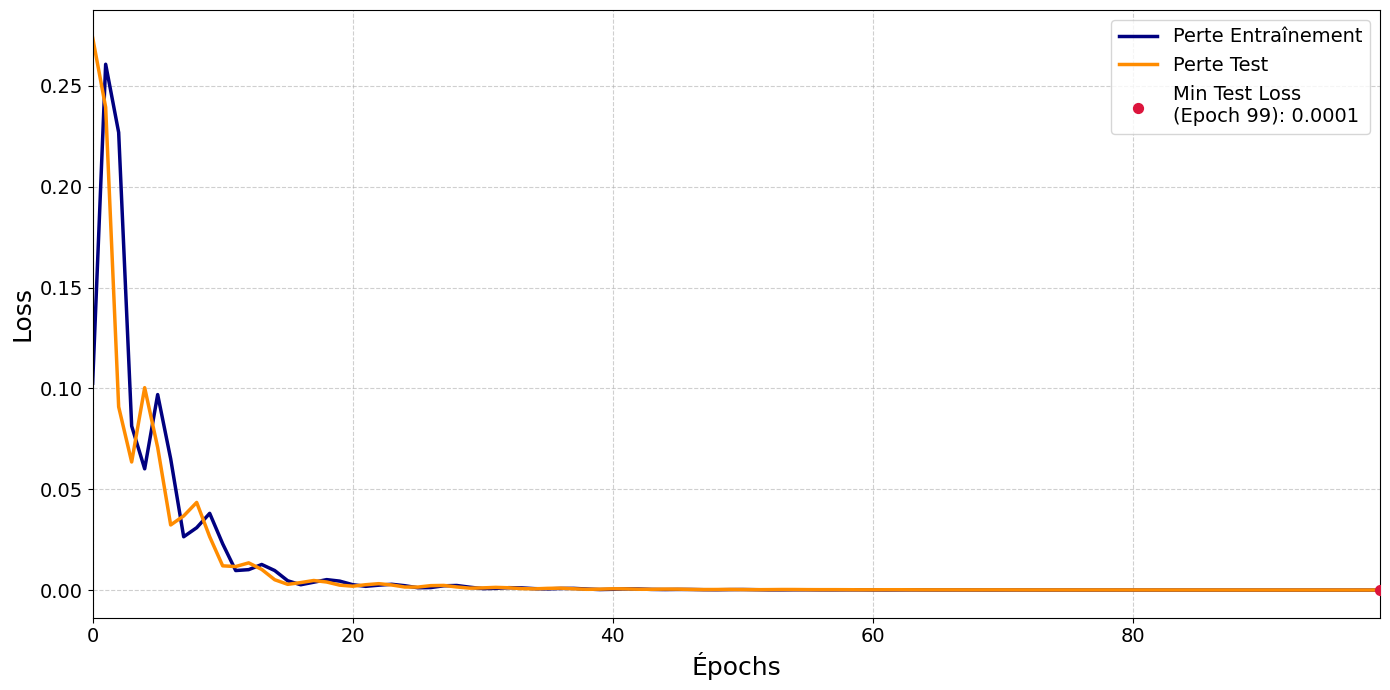

In [19]:
plot_losses(train_losses, test_losses, title="MLP Training")

In [20]:
def evaluate_model(model, X_test, y_test, scaler_y):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Inverser la normalisation
    y_test_orig = inverse_transform_y(y_test, scaler_y)
    y_pred_orig = inverse_transform_y(y_pred, scaler_y)

    # Calcul des métriques
    rmse = mean_squared_error(y_test_orig, y_pred_orig, squared=False)
    r2 = r2_score(y_test_orig, y_pred_orig)
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    return y_test_orig, y_pred_orig

c:\Users\TimWi_x1vpvf2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 5.5841, R²: 0.9991


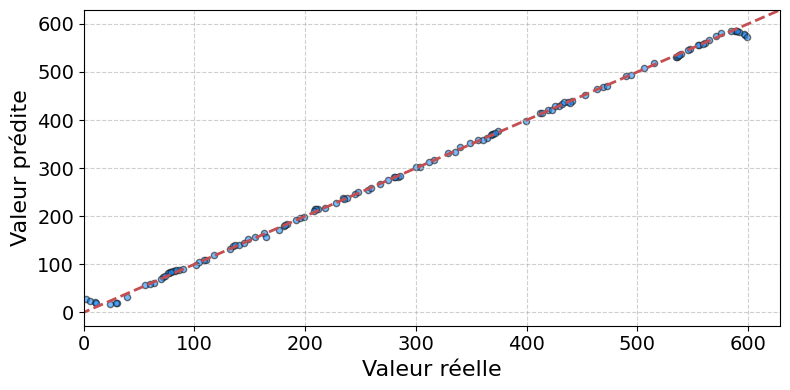

In [21]:
y_test_orig, y_pred_orig = evaluate_model(mlp_model, data['X_test'], data['y_test'], data['scaler_y'])
plot_predictions(mlp_model, data['X_test'], data['y_test'], data['scaler_y'], labels_std, title="MLP Predictions")